In [1]:
import pickle
from datetime import datetime
from sklearn import preprocessing
import pandas as pd
import numpy as np
import random
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sys
import math
sys.setrecursionlimit(10000)
warnings.filterwarnings('ignore')
random.seed(42)

from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape,Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
print("Load the training, test and store data using pandas")
train = pd.read_csv("train.csv")
train.index = train.Date
store = pd.read_csv("store.csv")
stores = pd.read_csv("store_states.csv")
train = pd.merge(train,stores,on = "Store")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 160)

Load the training, test and store data using pandas


In [3]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,State
0,1,5,2015-07-31,5263,555,1,1,0,1,HE
1,1,4,2015-07-30,5020,546,1,1,0,1,HE
2,1,3,2015-07-29,4782,523,1,1,0,1,HE
3,1,2,2015-07-28,5011,560,1,1,0,1,HE
4,1,1,2015-07-27,6102,612,1,1,0,1,HE


In [4]:
### Test and Train Separation ###
X_train = train[train.Date < '2015-04-01']
X_test = train[train.Date >= '2015-04-01']

In [5]:
### Create Features ####
def create_features(data):
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    data  =data[data.Open == 1]
    data.Date=pd.to_datetime(data.Date)
    Frame = []
    Frame.append((data["Store"].values))
    Frame.append((data["DayOfWeek"].values))
    Frame.append((data["Promo"].values))
    Frame.append((data.Date.dt.year.values))
    Frame.append((data.Date.dt.month.values))
    Frame.append((data.Date.dt.day.values))
    Frame.append((data['State'].values))
    Frame.append((data['Sales'].values))
    return Frame
    
X_train_features = create_features(X_train)
X_test_features = create_features(X_test)
x_trai = []
x_tes = []
for i in range(len(X_train_features)-1):

    le = preprocessing.LabelEncoder()
    le.fit(X_train_features[i])
    x_trai.append(le.transform(X_train_features[i]))
    x_tes.append(le.transform(X_test_features[i]))
    
    

In [6]:
max_log_y = max(np.max(np.log(X_train_features[7])), np.max(np.log(X_test_features[7])))
def _val_for_fit(val,max_log_y):
    val = np.log(val+1) / max_log_y
    return val
print(max_log_y)

10.634676867382668


In [7]:
input_store = Input(shape=(1,))
output_store = Embedding(1115, 10, name='store_embedding')(input_store)
output_store = Reshape(target_shape=(10,))(output_store)

input_dow = Input(shape=(1,))
output_dow = Embedding(7, 6, name='dow_embedding')(input_dow)
output_dow = Reshape(target_shape=(6,))(output_dow)

input_promo = Input(shape=(1,))
output_promo = Dense(1)(input_promo)

input_year = Input(shape=(1,))
output_year = Embedding(3, 2, name='year_embedding')(input_year)
output_year = Reshape(target_shape=(2,))(output_year)

input_month = Input(shape=(1,))
output_month = Embedding(12, 6, name='month_embedding')(input_month)
output_month = Reshape(target_shape=(6,))(output_month)

input_day = Input(shape=(1,))
output_day = Embedding(31, 10, name='day_embedding')(input_day)
output_day = Reshape(target_shape=(10,))(output_day)

input_germanstate = Input(shape=(1,))
output_germanstate = Embedding(12, 6, name='state_embedding')(input_germanstate)
output_germanstate = Reshape(target_shape=(6,))(output_germanstate)

input_model = [input_store, input_dow, input_promo,
               input_year, input_month, input_day, input_germanstate]

output_embeddings = [output_store, output_dow, output_promo,
                     output_year, output_month, output_day, output_germanstate]

output_model = Concatenate()(output_embeddings)
output_model = Dense(1000, kernel_initializer="uniform")(output_model)
output_model = Dropout(0.2)(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(500, kernel_initializer="uniform")(output_model)
output_model = Dropout(0.2)(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(1)(output_model)
output_model = Activation('sigmoid')(output_model)

model = KerasModel(inputs=input_model, outputs=output_model)

model.compile(loss='mean_absolute_error', optimizer='adam')

In [195]:
model.fit(x_trai,_val_for_fit(X_train_features[7],max_log_y),
                       validation_data=(x_tes, _val_for_fit(X_test_features[7],max_log_y)),
                       epochs=3, batch_size=128
                       )

Train on 732970 samples, validate on 111422 samples
Epoch 1/3
732970/732970 [==============================] - 51s 70us/step - loss: 0.0071 - val_loss: 0.0095
Epoch 2/3
732970/732970 [==============================] - 54s 74us/step - loss: 0.0070 - val_loss: 0.0094
Epoch 3/3
732970/732970 [==============================] - 53s 73us/step - loss: 0.0070 - val_loss: 0.0093


In [10]:
model.save("Best_iteration")

def _val_for_pred(val):
    return np.exp((val* max_log_y))-1

In [11]:
model.load_weights("Best_iteration")

In [12]:
test = X_test[X_test.Store==6]
def create_features(data):
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    data.Date=pd.to_datetime(data.Date)
    Frame = []
    Frame.append((data["Store"].values))
    Frame.append((data["DayOfWeek"].values))
    Frame.append((data["Promo"].values))
    Frame.append((data.Date.dt.year.values))
    Frame.append((data.Date.dt.month.values))
    Frame.append((data.Date.dt.day.values))
    Frame.append((data['State'].values))
    Frame.append((data['Sales'].values))
    return Frame
test_features = create_features(test)
x_val = []
for i in range(len(X_train_features)-1):

    le = preprocessing.LabelEncoder()
    le.fit(X_train_features[i])
    x_val.append(le.transform(test_features[i]))
    
result = model.predict(x_val).flatten()
test["predict"] = _val_for_pred(result)
test["predict"][test.Open != 1]= 0 
measure = math.pow(mean_squared_error(test["predict"],test['Sales'].values), 0.5)
print("RMSE:", measure)

RMSE: 517.6544845372765


In [17]:
test.index = test.Date
test= test.sort_values("Date")

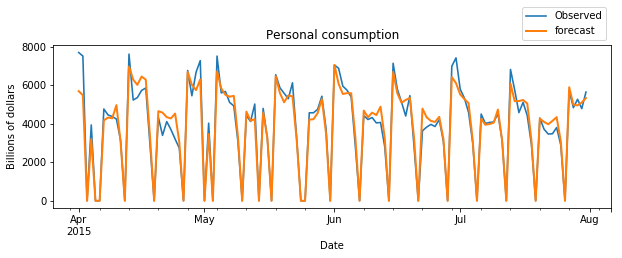

In [18]:
# Dynamic predictions
# Graph
fig, ax = plt.subplots(figsize=(10,3))
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

t_start='2015-01-01'
pred_start = '2014-04-01'
t_end='2015-07-31'
test.Sales.plot(ax=ax, style='-',linewidth=1.6, label='Observed')
test.predict.plot(ax=ax,style='-',linewidth=2, label='forecast')
legend = ax.legend(loc='lower right',bbox_to_anchor=(1,1))